Первым делом следует подключить все необходимые библиотеки.

In [128]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from collections import OrderedDict
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import numpy as np
import scipy.special
import os.path
import os
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from time import time
import pandas as pd

Теперь необходимо предварительно обработать и векторизовать наши данные. Предобработку будем выполнять, используя библиотеку NLTK. Для токенизации (разбиения текста на слова) будем использовать RegexpTokenizer из модуля nltk.tokenize. В него необходимо передать регулярное выражение. Далее слова необходимо привести к нижнему регистру и удалить служебные части речи. Для этого можно воспользоваться функцией pos_tag, которая присваивает каждому слову метку части речи (или ставит метку, что данная строка не является словом). 

Также можно заметить, что в этой функции используется стэмминг, суть которого заключается в отбрасывании суффиксов и приставок у слов. Это позволяет сократить размерность признаков, так как слова с разными родами и падежами будут сокращены до одинаковых лексем. Для стемминга будем использовать SnowballStemmer из модуля nltk.stem.snowball. Существует более мощный аналог стэмминга – лемматизация, она позволяет восстановить начальную форму слова. Однако работает она медленнее стэмминга, и, помимо этого, в NLTK нет русского лемматизатора.

Функция обработки будет возвращать Pandas DataFrame, строки которого будут соответствовать файлам, для которых будут определены обработанный текст и тип отзыва.

In [47]:
def great_process(labels):
    data = {"File": [], "Words": [], "Label": []}
    tokenizer = RegexpTokenizer(r"\w+|[\W\s]+")
    stemmer = SnowballStemmer("russian")
    for label in labels:
        for c_dir, _, files in os.walk("D:\МЭИ\Практика\Отзывы к фильмам\{}".format(label)):
            for file in files:
                with open("D:\МЭИ\Практика\Отзывы к фильмам\{}\{}".format(label, file), encoding='utf-8') as f:
                    words = f.read()
                    bag_words = tokenizer.tokenize(words) # Токенезация
                    # Приведение к нижнему регистру
                    for i in bag_words:
                        i = i.lower()
                    # Присвоение частей речи
                    pos_words = pos_tag(bag_words, lang='rus')
                    # Очищение от служебных слов
                    cleaned_words = []
                    for i in pos_words:
                        if i[1] in ['S', 'A', 'V', 'ADV']:
                            cleaned_words.append(stemmer.stem(i[0]))
                text = " ".join(cleaned_words)
                data["File"].append(file[:-4] + '_' + label)
                data["Words"].append(text)
                data["Label"].append(label)
        print(label)
    return pd.DataFrame(data)

In [48]:
df = great_process(['neutral', 'bad', 'good'])

neutral
bad
good


In [49]:
df

,File,Words,Label
0,0_neutral,нача показател груб дерзк лома мейнстрим одаре...,neutral
1,1_neutral,откровен говор удивля феном режиссер тарантин ...,neutral
2,10_neutral,квентин тарантин скаж честн явля режиссер филь...,neutral
3,100_neutral,ход кинотеатр восторг чувств сторон действител...,neutral
4,1000_neutral,фанат очен долг ждал момент почт команд сбор л...,neutral
...,...,...,...
2995,995_good,моряк слишк долг плава успел позаб нрав дьявол...,good
2996,996_good,анонс выход экра част экшн франшиз форсаж был ...,good
2997,997_good,нача фильм шедевр фильм феном сдела кристофер ...,good
2998,998_good,призна честн посмотрел фильм вчер ран возможн ...,good


Делим данные на обучающую и тестовую выборку:

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df['Words'], 
                                                    df['Label'], 
                                                    test_size=0.15, 
                                                    random_state=8)

Далее следует выполнить векторизацию, то есть представление наших текстовых данных в числовые, чтобы их смог обработать компьютер. Существует несколько способов векторизации. В данной работе будут использоваться TF-IDF векторы для представления отзывов. 

TF-IDF значение увеличивается пропорционально количеству появлений слова в документе и смещается на количество документов в выборке, содержащих слово, что помогает отрегулировать тот факт, что некоторые слова появляются чаще. Данный метод также учитывает тот факт, что некоторые документы могут быть больше, чем другие, путем нормализации частот.

Выбор именно этого типа векторизации мотивирован следующими моментами:
    * TF-IDF это простая модель, которая дает отличные результаты при анализе текстовой информации, как мы увидим позже;
    * Это достаточно быстрый процесс, что важно при большом числе файлов;
    * Мы можем контролировать процесс векторизации подбором параметров.
    
При создании объектов с помощью этого метода мы можем выбрать несколько параметров:
    * Диапазон N-грамм (сочетания N соседних слов): мы можем рассматривать униграммы, биграммы, триграммы…
    * Максимальная / минимальная частота в документах: при построении словаря мы можем игнорировать термины, у которых частота в документах строго выше / ниже заданного порога.
    * Максимум параметров: мы можем выбрать N параметров (терминов), наиболее встречаемых в документах.
    
Логично ожидать, что биграммы и триграммы могут улучшить производительность модели. При подборе оптимальных параметров будут испытаны три варианта модели: с использованием униграмм; униграмм и биграмм; униграмм, биграмм и триграмм. Значение Minimum DF необходимо настроить, чтобы избавиться от чрезвычайно редких слов, которые не появляются в более чем min_df документах (будем подбирать в пределах от 5 до 100 с шагом 5), а Maximum DF установим 100%, чтобы не игнорировать любые другие слова. Максимальное количество параметров необходимо настроить, чтобы избежать возможного переоснащения, часто возникающего из-за большого количества параметров по сравнению с количеством обучающих наблюдений (будем подбирать в пределах от 500 до 10000 с шагом 500).

In [58]:
# Функция для удобства подбора параметров векторизации
def Vector_Apply(ngram_range, min_df, max_features): 
    tfidf = TfidfVectorizer(encoding='utf-8',
                            ngram_range=ngram_range,
                            stop_words=None,
                            lowercase=False,
                            max_df=1.,
                            min_df=min_df,
                            max_features=max_features,
                            norm='l2',
                            sublinear_tf=True)
                        
    features_train = tfidf.fit_transform(X_train).toarray()
    labels_train = y_train

    features_test = tfidf.transform(X_test).toarray()
    labels_test = y_test
    return features_train, features_test, labels_train, labels_test

Для подбора параметров векторизации можно использовать модель RandomForest. Пока у нас нет возможности провести кросс_валидацию и подбор оптимальных параметров модели. Возьмем глубину деревьев 15, а остальные параметры оставим по умолчанию.

In [78]:
ngram_range_list = [(1, 1), (1, 2), (1, 3)]
min_df_list = list(range(5, 101, 5))
max_features_list = list(range(500, 10001, 500))
res = {'ngram_range':[], 'min_df':[], 'max_features':[], 'score':[]}
for ngram_range in ngram_range_list:
    for min_df in min_df_list:
        for max_features in max_features_list:
            features_train, features_test, labels_train, labels_test = Vector_Apply(ngram_range, min_df, max_features)
            clf = RandomForestClassifier(max_depth=15)
            clf.fit(features_train, labels_train)
            predicted = clf.predict(features_test)
            score = accuracy_score(labels_test, predicted)
            res['ngram_range'].append(ngram_range)
            res['min_df'].append(min_df)
            res['max_features'].append(max_features)
            res['score'].append(score)
            print(max_features)
        print(min_df)
    print(ngram_range)
res_df = pd.DataFrame(res)
res_df

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
5
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
15
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
20
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
25
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
30
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
35
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
40
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
45
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500


,ngram_range,min_df,max_features,score
0,"(1, 1)",5,500,0.582222
1,"(1, 1)",5,1000,0.575556
2,"(1, 1)",5,1500,0.562222
3,"(1, 1)",5,2000,0.582222
4,"(1, 1)",5,2500,0.591111
...,...,...,...,...
1195,"(1, 3)",100,8000,0.582222
1196,"(1, 3)",100,8500,0.584444
1197,"(1, 3)",100,9000,0.571111
1198,"(1, 3)",100,9500,0.566667


In [82]:
max_score = res_df['score'].max()
res_df.query('score == @max_score')

,ngram_range,min_df,max_features,score
89,"(1, 1)",25,5000,0.624444
348,"(1, 1)",90,4500,0.624444


Как видно из проведенного исследования, максимальная точность была получена при двух разных сочетаниях параметров. Можно заметить, что использование биграмм и триграмм не сыграло решающей роли в качестве классификации. Так как у нас 2 возможных варианта параметров, рационально выбрать тот, в котором max_features меньше, так как это поможет сократить количество признаков и сэкономить время для обучения моделей.

In [90]:
params = res_df.query('(score == @max_score) & (max_features == 4500)')
ngram_range = params['ngram_range'].values[0]
min_df = params['min_df'].values[0]
max_features = params['max_features'].values[0]
features_train, features_test, labels_train, labels_test = Vector_Apply(ngram_range, min_df, max_features)

Следующим шагом является применение методов машинного обучения. Начнем с метода опорных векторов. Так как в текстовых данных всегда большое число параметров (терминов), то лучше всего будет использовать линейную гиперплоскость для классификации. В следствие этого пропадает необходимость в кросс-валидации для подбора параметров C и Гамма. Они будут равны 1 и 0 соответственно (значения по умолчанию).

In [110]:
model = svm.SVC(kernel='linear') 
model.fit(features_train, labels_train)
predicted_SVC = model.predict(features_test)
# Точность на контрольном датасете
score_test = accuracy_score(labels_test, predicted_SVC)
print(score_test)
# Классификационный отчет
report = classification_report(labels_test, predicted_SVC)
print(report)

0.5866666666666667
              precision    recall  f1-score   support

         bad       0.60      0.61      0.60       138
        good       0.64      0.64      0.64       152
     neutral       0.53      0.51      0.52       160

    accuracy                           0.59       450
   macro avg       0.59      0.59      0.59       450
weighted avg       0.59      0.59      0.59       450



Как можно заметить из классификационного отчета, точность определения нейтральных отзывов несколько ниже остальных. Вероятно, это связано с тем, что в нейтральных отзывах наблюдаются признаки как положительных, так и отрицательных типов. Визуализируем полученный результат в виде матрицы ошибок. Для этого напишем следующую функцию, которая представит данную матрицу в виде графика:

In [93]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}
plt.rc('font', **font)

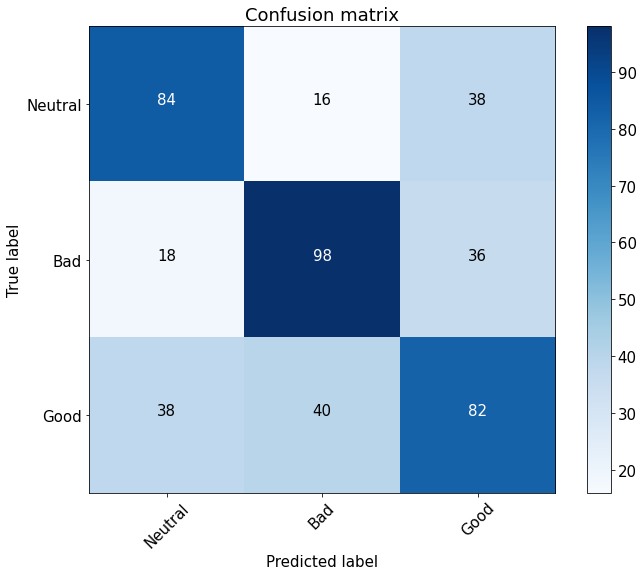

In [111]:
cnf_matrix = confusion_matrix(labels_test, model.predict(features_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Neutral', 'Bad', 'Good'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Как видно из полученной матрицы, самое большое количество неправильно классифицированных отзывов именно среди нейтральных, что ещё раз подтверждает сделанный вывод.

Переходим к методу Случайный Лес, который использовался для подбора параметров векторизации. Попробуем оптимизировать его параметры. Мы будем использовать алгоритм RandomizedSearchCV. Он позволяет исследовать широкие диапазоны значений. Создается словарь params, в котором для каждого параметра задан диапазон его изменений. Затем создается объект RS с помощью функции RandomizedSearchCV(), передавая ей модель, params, число итераций и число кросс-валидаций, которые нужно выполнить.

Нас будут интересовать параметры: * n_estimators — число «деревьев» в «случайном лесу». * max_features — число признаков для выбора расщепления. * max_depth — максимальная глубина деревьев.

In [98]:
n_estimators = list(range(100, 1001, 100))
max_features = ['sqrt', 'log2']
max_depth = list(range(1, 31))
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
RS = RandomizedSearchCV(RandomForestClassifier(), 
                        param_dist, 
                        n_iter = 100, 
                        cv = 10, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
RS.fit(features_train, labels_train)
RS.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 21.5min finished


{'n_estimators': 900, 'max_features': 'log2', 'max_depth': 29}

Используем полученные параметры

In [100]:
model = RandomForestClassifier(n_estimators=900, max_features='log2', max_depth=29)
model.fit(features_train, labels_train)
predicted_FC = model.predict(features_test)
# Точность на контрольном датасете
score_test = accuracy_score(labels_test, predicted_FC)
print(score_test)
# Классификационный отчет
report = classification_report(labels_test, predicted_FC)
print(report)

0.6066666666666667
              precision    recall  f1-score   support

         bad       0.66      0.60      0.63       138
        good       0.60      0.66      0.63       152
     neutral       0.57      0.56      0.56       160

    accuracy                           0.61       450
   macro avg       0.61      0.61      0.61       450
weighted avg       0.61      0.61      0.61       450



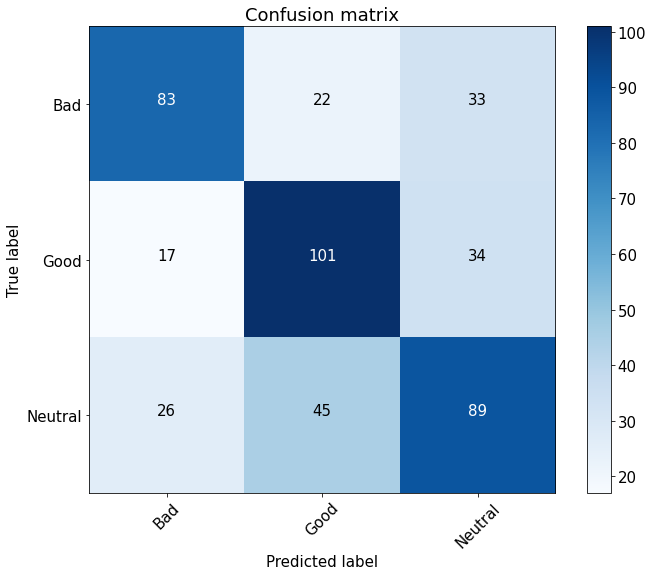

In [101]:
cnf_matrix = confusion_matrix(labels_test, model.predict(features_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Bad', 'Good', 'Neutral'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Данный метод показал более высокую точность, однако она по прежнему остается небольшой. Причем больше всего ошибок первого и второго рода, как можно заметить по матрице ошибок, допускается в отношении нейтральных отзывов. 

Далее используем метод К ближайших соседей. Для него достаточно оптимизировать лишь параметр К. Сделать это можно с помощью k-кратной перекрестной проверки. Проведем 10-кратную перекрестную проверку, используя сгенерированный список нечетных K в диапазоне от 1 до 50.

In [102]:
neighbors = list(range(1, 50, 2))
cv_scores = [ ]
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors=K)
    scores = cross_val_score(knn, features_train, labels_train, cv=10, scoring="accuracy")
    cv_scores.append(scores.mean())

Оптимальное значение К можно получить путем построения показателя точности для разных значений К.

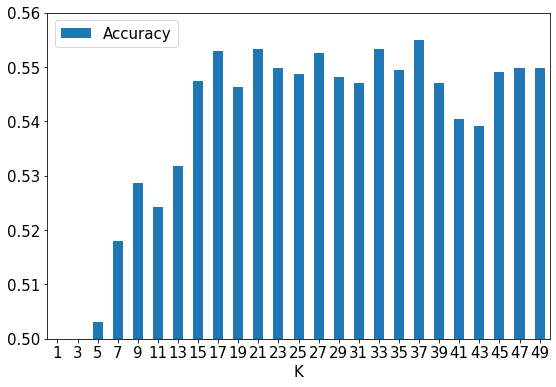

In [106]:
def plot_accuracy(scores):
    pd.DataFrame({"K":[i for i in range(1,50,2)], "Accuracy":scores}).set_index("K").plot.bar(figsize= (9,6),
                                                                                              ylim=(0.5,0.56),
                                                                                              rot=0)
    plt.show()
plot_accuracy(cv_scores)

Используем полученное значение К = 37.

In [112]:
model = KNeighborsClassifier(n_neighbors=37)
model.fit(features_train, labels_train)
predicted_KN = model.predict(features_test)
# Точность на контрольном датасете
score_test = accuracy_score(labels_test, predicted_KN)
print(score_test)
report = classification_report(labels_test, predicted_KN)
print(report)

0.5666666666666667
              precision    recall  f1-score   support

         bad       0.68      0.46      0.55       138
        good       0.53      0.82      0.64       152
     neutral       0.55      0.42      0.48       160

    accuracy                           0.57       450
   macro avg       0.59      0.57      0.56       450
weighted avg       0.58      0.57      0.56       450



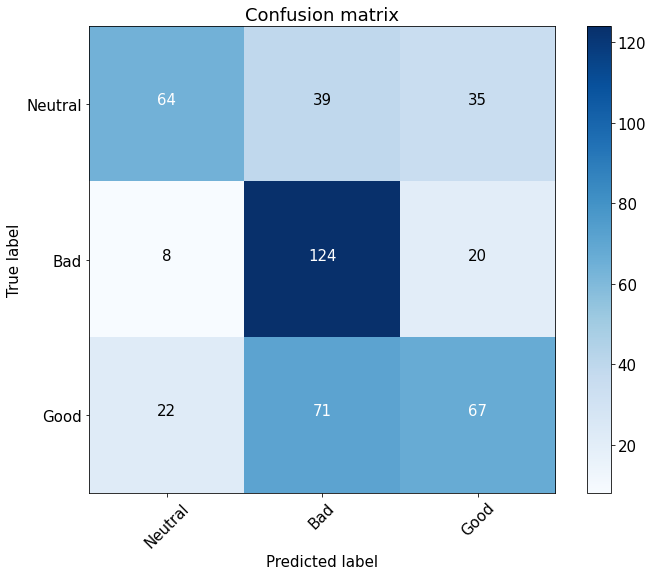

In [113]:
cnf_matrix = confusion_matrix(labels_test, model.predict(features_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Neutral', 'Bad', 'Good'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

В данной моделе очень хорошо определились плохие отзывы. А вот хорошие уступили даже нейтральным. Вообще, исходя из результатов моделей, кажется, что именно граница между хорошими и нейтральными отзывами размыта больше всего. Возможно, это связано с особенностями человеческого мышления.

Проведем краткий сравнительный анализ использованных методов. В качестве параметров для сравнения используем точность и время, затраченное на обучение и на анализ тестовой выборки. Напишем для визуализации сравнительной диаграммы следующую функцию.

In [132]:
def benchmark(clf, name):
    t0 = time()
    clf.fit(features_train, labels_train)
    train_time = time() - t0

    t0 = time()
    pred = clf.predict(features_test)
    test_time = time() - t0
    
    score = accuracy_score(labels_test, pred)
   
    return name, score, train_time, test_time

In [135]:
results = []
for clf, name in ((KNeighborsClassifier(n_neighbors=37), "kNN"),
                  (RandomForestClassifier(n_estimators=900, max_features='log2', max_depth=29), "Random forest"),
                  (svm.SVC(kernel='linear'), "SVC")):
    results.append(benchmark(clf, name))

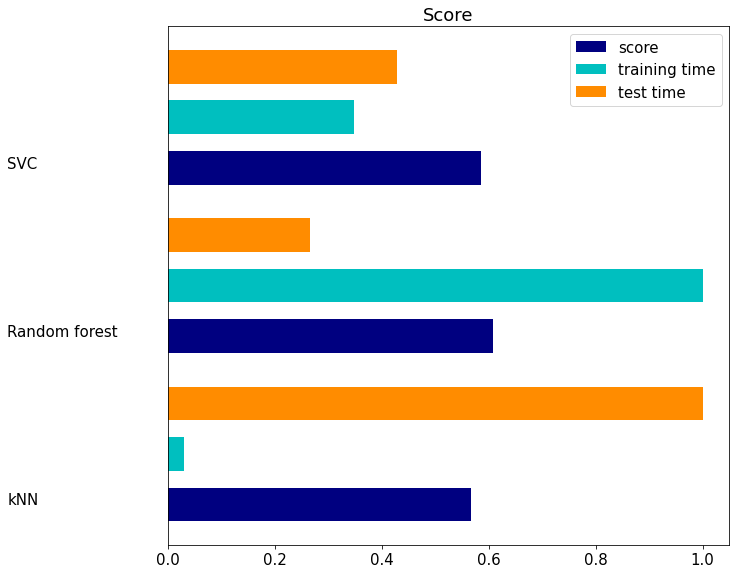

In [136]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

Исходя из полученной диаграммы можно сделать вывод, что самым точным оказался метод Случайный лес. Однако, он же и самый затратный по времени обучения. Самым оптимальным сочетанием точности и временных затарат обладает метод опорных векторов. А вот метод К ближайших соседей явно не подходит для анализа текстовых данных. Он обладает минимальной точностью при максимальном времени анализа тестовых данных. Скорее всего, он чувствителен к большому числу признаков, которого при анализе текстовой информации не избежать.